### Modeling Fakeddit
* [Paper](https://arxiv.org/pdf/1911.03854.pdf)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import preprocess_data, process_labels,split_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_cpu_metrics import train_early_fusion, train_late_fusion

In [2]:
PATH = 'Embeddings_vlm/fakeddit/'
FILE = 'embeddings_clip.csv'

FILE_PATH = os.path.join(PATH, FILE)

## Get data

In [3]:
df = pd.read_csv(FILE_PATH)
df.drop(columns=['hasImage', 'image_url'], inplace=True)
df.head()

,author,clean_title,created_utc,domain,id,linked_submission_id,num_comments,score,subreddit,title,...,text_embedding_502,text_embedding_503,text_embedding_504,text_embedding_505,text_embedding_506,text_embedding_507,text_embedding_508,text_embedding_509,text_embedding_510,text_embedding_511
0,michaelconfoy,loose talk got there first keep it under your ...,1.429942e+09,i.imgur.com,datasets/fakeddit/images/33snxf.jpg,NaN,6.0,70,propagandaposters,"""Loose talk got there first! Keep it under you...",...,0.017499,0.040466,0.121275,-0.046296,0.051412,0.016091,0.010176,0.065790,-0.091243,-0.035023
1,SaltMineForeman,this tree at my campsite naturally grew a hear...,1.554421e+09,i.imgur.com,datasets/fakeddit/images/b9k2ta.jpg,NaN,2.0,30,mildlyinteresting,This tree at my campsite naturally grew a hear...,...,-0.035342,0.014651,0.022642,-0.005436,-0.041879,0.019345,-0.020924,0.012200,-0.047352,0.045813
2,Shawn_666,fdr addressing the nation,1.522982e+09,i.redd.it,datasets/fakeddit/images/8a5wy9.jpg,NaN,1.0,12,fakehistoryporn,FDR addressing the nation (1932),...,-0.027288,0.020853,-0.003959,0.000404,0.034326,-0.029220,-0.002929,-0.065850,0.016998,0.019142
3,YOLO2THEMAX,face morph,1.448948e+09,NaN,datasets/fakeddit/images/cxiu2qb.jpg,3urf4a,NaN,2,psbattle_artwork,Face morph,...,-0.011685,-0.003866,0.037784,0.010292,-0.004787,0.003773,-0.012201,-0.028986,-0.010641,-0.032186
4,FarMojo,a japanese kamikaze pilot of the sixth air arm...,1.559169e+09,i.redd.it,datasets/fakeddit/images/bul96p.jpg,NaN,0.0,8,fakehistoryporn,A Japanese kamikaze pilot of the sixth air arm...,...,0.021707,0.011216,0.022868,-0.023618,-0.039166,-0.000059,0.033039,-0.088854,0.024785,-0.023957


## Data Perparation

In [4]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = '2_way_label'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Train Shape: (56214, 1039)
Test Shape: (5911, 1039)


### Models

In [5]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
if label_columns == '2_way_label':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
Model Memory Usage: 0.50 MB
The number of parameters of the model are: 131585


STAGE:2024-02-07 18:14:06 57022:57022 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Epoch 1/5 - Test Accuracy: 0.9249
Epoch 1/5 - Training Time: 5.87 seconds | Inference Time: 0.40 seconds
Epoch 2/5 - Test Accuracy: 0.9256
Epoch 2/5 - Training Time: 4.84 seconds | Inference Time: 0.38 seconds
Epoch 3/5 - Test Accuracy: 0.9284
Epoch 3/5 - Training Time: 3.48 seconds | Inference Time: 0.41 seconds
Epoch 4/5 - Test Accuracy: 0.9279
Epoch 4/5 - Training Time: 3.65 seconds | Inference Time: 0.42 seconds
Epoch 5/5 - Test Accuracy: 0.9284
Epoch 5/5 - Training Time: 3.50 seconds | Inference Time: 0.44 seconds


STAGE:2024-02-07 18:14:34 57022:57022 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-07 18:14:34 57022:57022 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         training_batch        10.15%        2.291s        66.57%       15.025s       3.419ms      -1.07 Gb      -1.10 Gb          4395  
                              Optimizer.step#AdamW.step         6.83%        1.541s        33.10%        7.470s       1.700ms       1.00 Mb      -4.24 Gb          4395  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        30.22%        6.820s        30.81%        6.953s       1.428ms       1.18 Gb       1.18

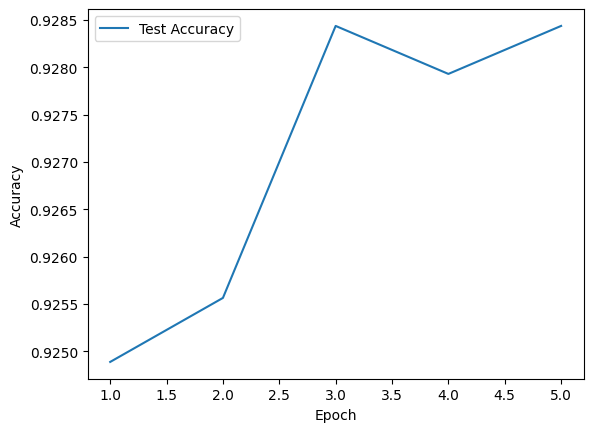

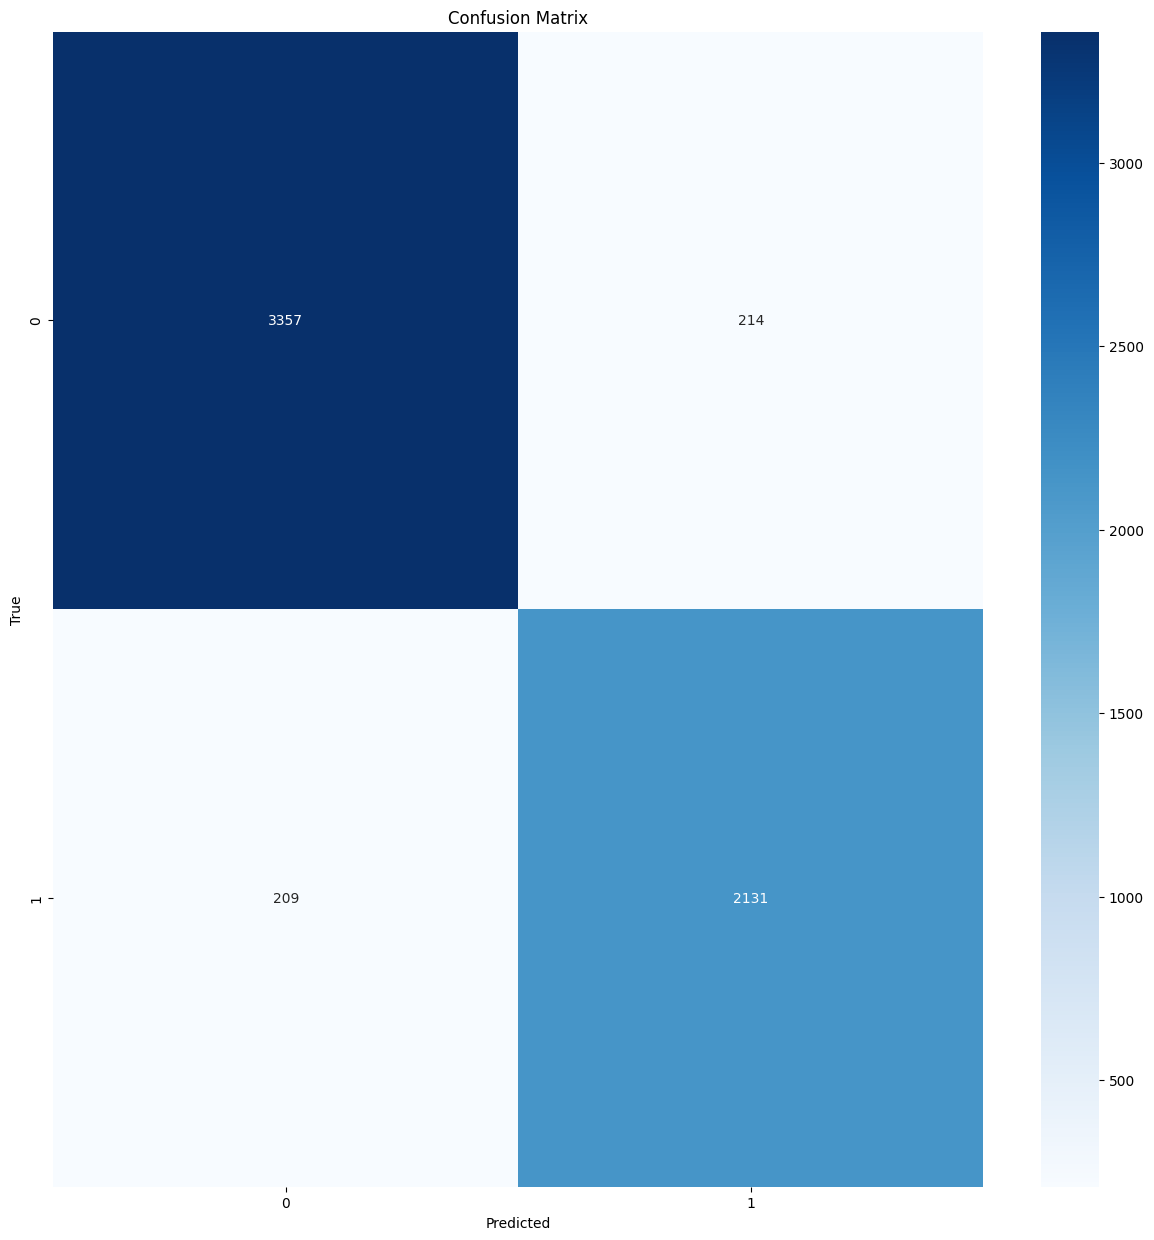

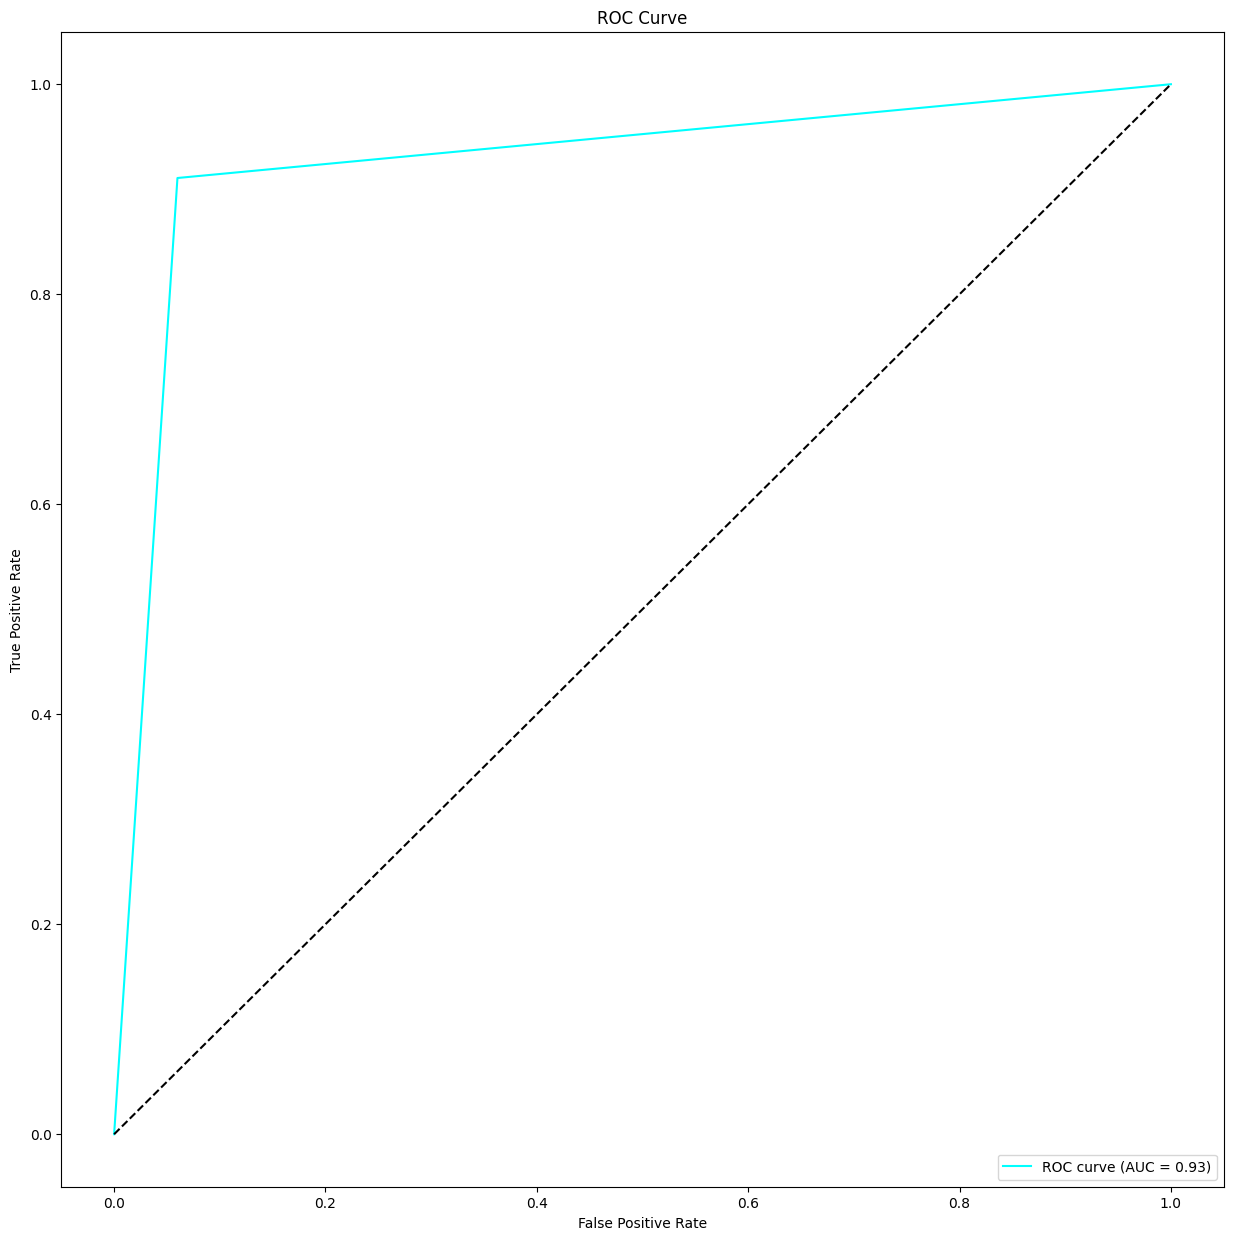

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      3571
         1.0       0.91      0.91      0.91      2340

    accuracy                           0.93      5911
   macro avg       0.93      0.93      0.93      5911
weighted avg       0.93      0.93      0.93      5911



In [6]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=5, multilabel=multilabel, report=True, p=0.2)

Training Late Fusion Model:
Model Memory Usage: 0.25 MB
The number of parameters of the model are: 66049


STAGE:2024-02-07 18:17:36 57022:57022 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Epoch 1/5 - Test Accuracy: 0.9190
Epoch 1/5 - Training Time: 5.88 seconds | Inference Time: 0.49 seconds
Epoch 2/5 - Test Accuracy: 0.9239
Epoch 2/5 - Training Time: 6.06 seconds | Inference Time: 0.48 seconds
Epoch 3/5 - Test Accuracy: 0.9257
Epoch 3/5 - Training Time: 6.31 seconds | Inference Time: 0.50 seconds
Epoch 4/5 - Test Accuracy: 0.9237
Epoch 4/5 - Training Time: 5.50 seconds | Inference Time: 0.54 seconds
Epoch 5/5 - Test Accuracy: 0.9266
Epoch 5/5 - Training Time: 4.44 seconds | Inference Time: 0.53 seconds


STAGE:2024-02-07 18:18:13 57022:57022 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-07 18:18:14 57022:57022 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         training_batch         9.20%        2.660s        74.30%       21.489s       4.422ms      -1.19 Gb      -1.21 Gb          4860  
                              Optimizer.step#AdamW.step         7.31%        2.114s        36.95%       10.687s       2.432ms     516.05 Kb      -2.12 Gb          4395  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        25.13%        7.267s        25.63%        7.412s       1.522ms       1.18 Gb       1.18

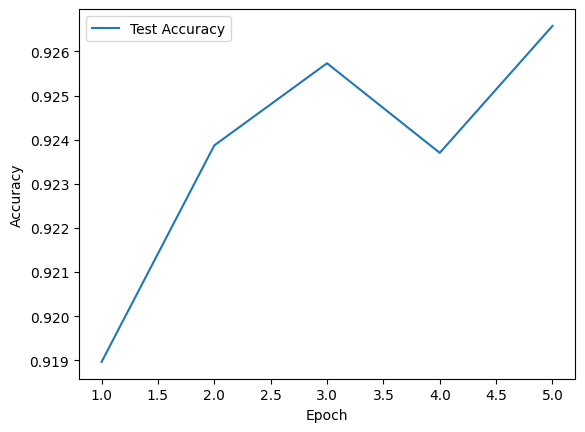

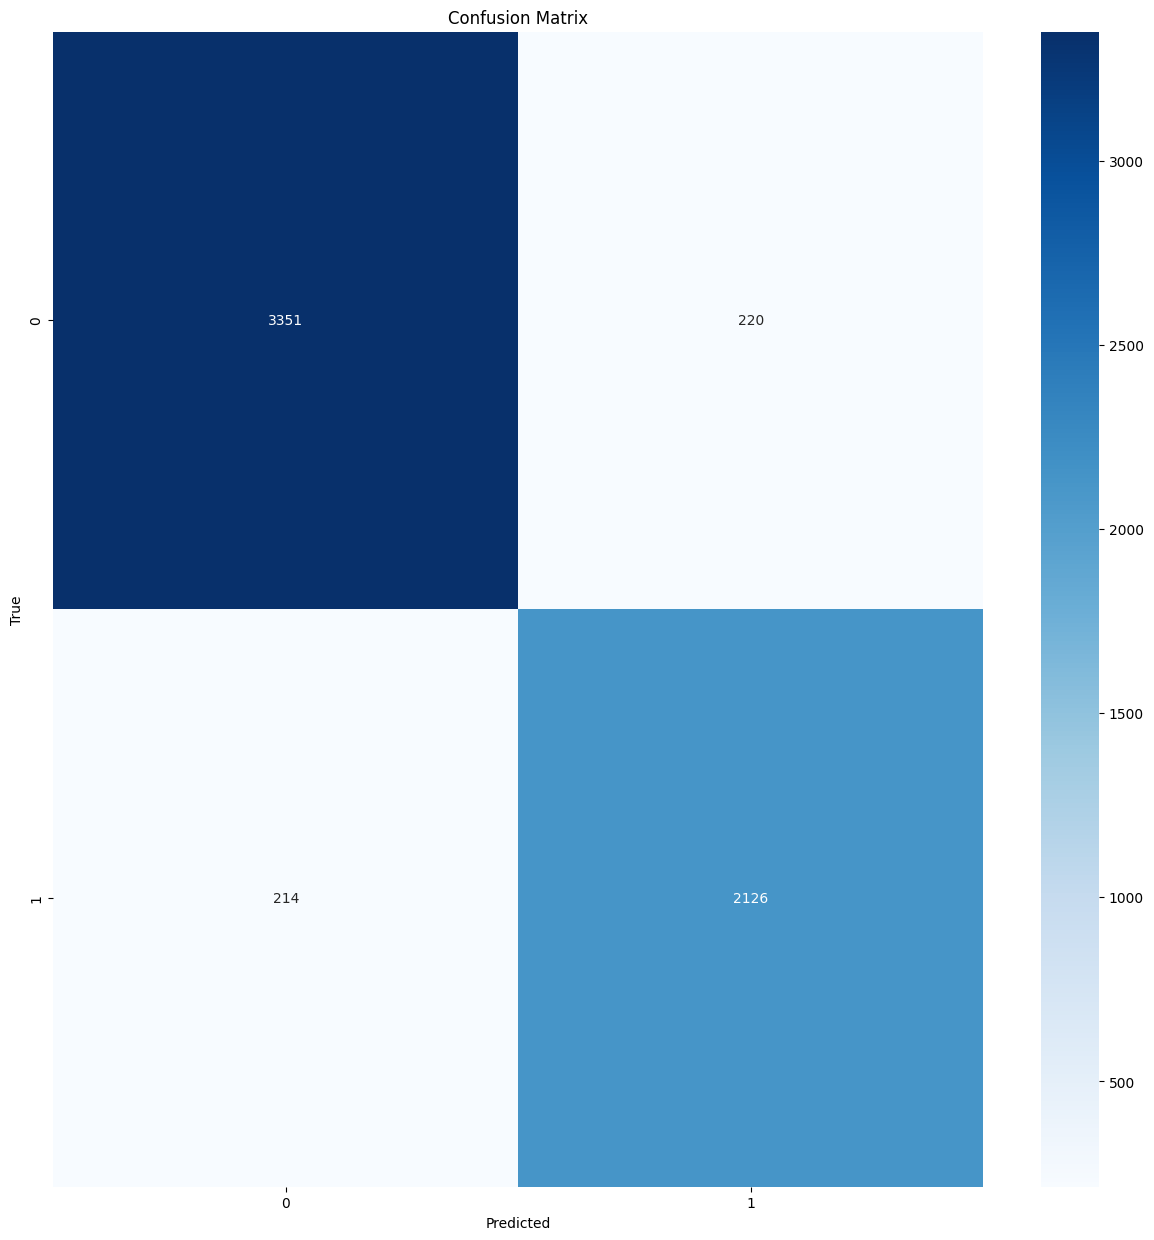

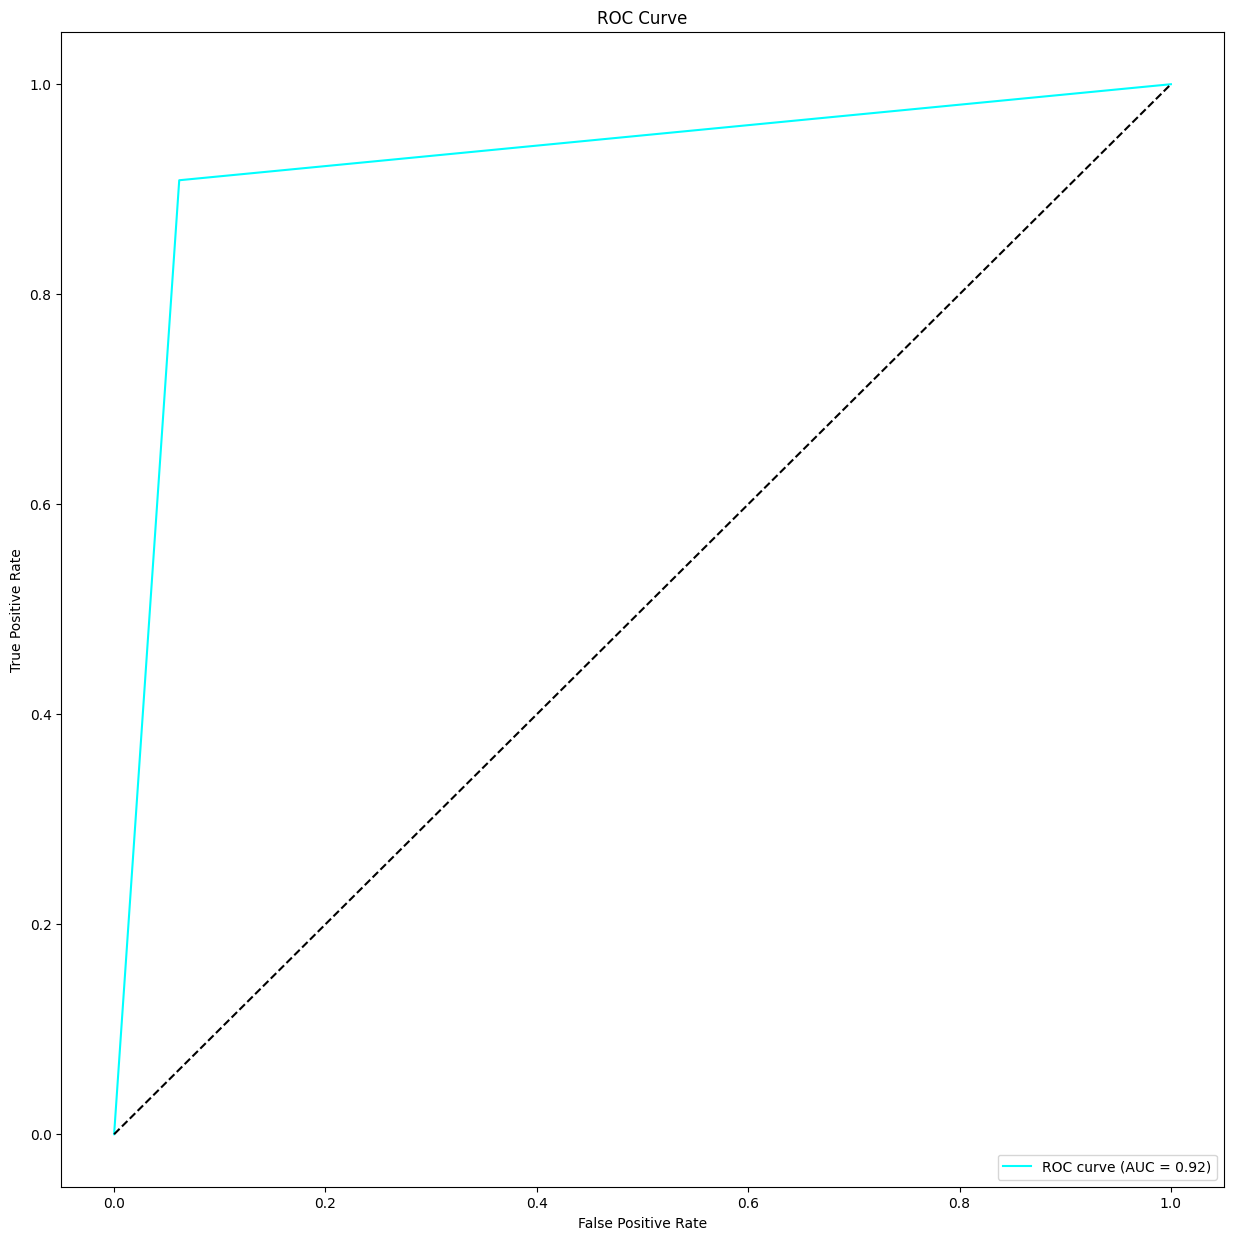

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      3571
         1.0       0.91      0.91      0.91      2340

    accuracy                           0.93      5911
   macro avg       0.92      0.92      0.92      5911
weighted avg       0.93      0.93      0.93      5911



In [7]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=5, multilabel=multilabel, report=True, p=0.2)